In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.transform import AffineTransform, warp
from skimage.util import random_noise
from skimage.transform import resize
from tensorflow.keras.models import Sequential
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tarfile
import os
from PIL import Image
import PIL.ImageEnhance as ImageEnhance
import requests
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import torchvision

2024-04-18 20:16:12.611738: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/isabellaschrufer/anaconda3/envs/MLAssignments/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/isabellaschrufer/anaconda3/envs/MLAssignments/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/isabellaschrufer/anaconda3/envs/MLAssignments/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/isabellaschrufer/anaconda3/envs/MLAssignments/lib/python3.11/site-packages/torch/lib/libc10.dylib'If you don't 

In [5]:
"""Getting df with all filenames and images (missing labels at this stage) - shape = (166866,2)"""
# only take first ten photos in each brand folder
# (150,150) grayscale --> 2m 28.9s
# (150,150) rgb, with pixels as cols --> 

def load_images_from_folder(folder_path, image_size=(150, 150)):
    images = []
    
    # Recursively traverse through the folder structure
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            # Get the full path of the file
            file_path = os.path.join(root, filename)
            
            # Check if the file is an image
            if any(filename.endswith(extension) for extension in ['.jpg', '.jpeg', '.png', '.gif']):
                # Load the image using PIL (Python Imaging Library)
                try:
                    with Image.open(file_path) as img:
                        img = img.resize(image_size) #resizing image
                        img = img.convert('L') #Converting to gray scale
                        #img_array = np.array(img) / 255.0 # Convert the image to numpy array and normalize pixel values
                         # Extract folder name from the root path
                        label = os.path.basename(root)
                        
                        images.append({'Label': label, 'Filename': filename, 'Image': img})
                        #images.append({'Filename': filename, 'Image': img}) # Append the image array to the list
                except Exception as e:
                    print(f"Error loading image '{file_path}': {e}")
    
    # Convert the list of dictionaries to a DataFrame
    images_df = pd.DataFrame(images)
    return images_df

# Loading
folder_path = '/Users/isabellaschrufer/Downloads/datasetcopy/trainandtest/train/Transportation'
image_df = load_images_from_folder(folder_path)
print('Image Dataframe: \n \n', image_df.head())

Image Dataframe: 
 
             Label Filename                                              Image
0  HaiNanAirlines   62.jpg  <PIL.Image.Image image mode=L size=150x150 at ...
1  HaiNanAirlines   60.jpg  <PIL.Image.Image image mode=L size=150x150 at ...
2  HaiNanAirlines   48.jpg  <PIL.Image.Image image mode=L size=150x150 at ...
3  HaiNanAirlines   49.jpg  <PIL.Image.Image image mode=L size=150x150 at ...
4  HaiNanAirlines   61.jpg  <PIL.Image.Image image mode=L size=150x150 at ...


In [14]:
print(image_df.count())

Filename    14719
Image       14719
dtype: int64


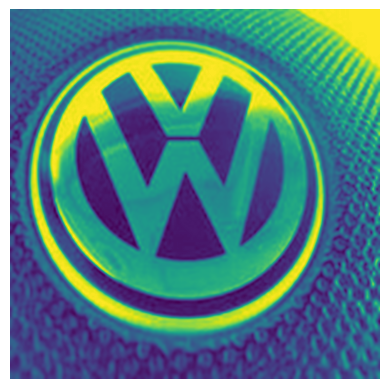

In [15]:
# Selecting one picture from the DataFrame
some_pic = image_df['Image'].iloc[102]

# Display the image using matplotlib
plt.imshow(some_pic, interpolation="lanczos")
plt.axis("off")
plt.show()

In [6]:
# Initialize an empty list to store the car brands
car_brands = []

for root, dirs, files in os.walk(folder_path):
    # Check if the subfolders represent car brands
    for brand_folder in dirs:
        # Append the car brand to the list
        car_brands.append(brand_folder)

# Print the list of car brands
print('Car Brands:')
for brand in car_brands:
    print(brand)
    
print(len(car_brands))

Car Brands:
HaiNanAirlines
Volkswagen
Porsche
AmericanStarBicycle
Fuji
Delta
Husqvarna
Lifan
Bharat
Montague
Vredestein
Mitsubishi
Alpine
Caloi
Renault
Micro
GTBicycles
DeRosa
LEAR
GMC
AstonMartin
sun
AmericanBicycle
Cello
Atlanta
Pagani
Hindustan
Anteros
Lincoln
AlfaRomeo
GrafStift
BP
Bertone
OKQ8
Electra
Isuzu
Merlin
Vulcan
McLaren
Landwind
Daewoo
Amuza
Caltex
ScotRail
Phillips66
MINI
Kuota
Jeep
Mazda
PIRELLI
Olmo
MG
DS
SantaMaria
Bentley
Daihatsu
Momentum
Boost
Brilliance
Birdy
Turbo
Shell
ANCAP
Argon18
Bridgestone
Lamborghini
Barrow
SantaFe
Beko
Puch
Buick
Strada
Motobecane
TVR
Mavic
LotusCars
HeroCycles
Raleigh
TrekBicycle
BYD
Ruger
Marussia
Barracuda
Bajaj
Tesla
Hyundai
Benelli
Kia
Overland
Yamaha
Pemex
Tracker
Arash
Chevrolet
Bristol
KogswellCycles
Valero
Koryo
Specialized
Orlando
Kona
Associated
Dacia
Infiniti
landrover
Polo
Toyota
Caparo
Mongoose
Saga
Canon
SCOTT
Holden
Orbea
KogaMiyata
Cadillac
Nissan
Orlen
Dodge
Acura
Diamant
Accel
Capri
Audi
Total
Steyr
Adio
BerlinRacycle
L

In [7]:
"""Loading Labels & Merging (37.9s to load)"""

# Loading Labels
label_path = '/Users/isabellaschrufer/Downloads/datasetcopy/List/train_images.txt'
labeltranslator = pd.read_csv(label_path, sep = '/', header = None, names = ['Label','Filename'])
print('Label-Translator Dataframe: \n \n', labeltranslator.head())

# Extract brand names from file names
labeltranslator['Label'] = labeltranslator['Label'].apply(lambda x: x.split('/')[0])

# Filter labels for only the unique transportation-related brands
transportation_labels = labeltranslator[labeltranslator['Label'].isin(car_brands)]

print(transportation_labels.head())

# Merging 
merged_df = image_df.merge(right = transportation_labels, how = 'inner', on = ['Label','Filename'])

#Encoding labels
label_encoder = LabelEncoder()
merged_df['Label coded'] = label_encoder.fit_transform(merged_df['Label'])
print('Merged Dataframe: \n \n', merged_df.head())

Label-Translator Dataframe: 
 
      Label Filename
0  24seven    1.jpg
1  24seven   10.jpg
2  24seven   11.jpg
3  24seven   14.jpg
4  24seven   16.jpg
        Label Filename
106705  Abici   10.jpg
106706  Abici   12.jpg
106707  Abici   15.jpg
106708  Abici   16.jpg
106709  Abici   17.jpg
Merged Dataframe: 
 
         Label Filename                                              Image  \
0  Volkswagen   48.jpg  <PIL.Image.Image image mode=L size=150x150 at ...   
1  Volkswagen   49.jpg  <PIL.Image.Image image mode=L size=150x150 at ...   
2  Volkswagen    8.jpg  <PIL.Image.Image image mode=L size=150x150 at ...   
3  Volkswagen    9.jpg  <PIL.Image.Image image mode=L size=150x150 at ...   
4  Volkswagen   28.jpg  <PIL.Image.Image image mode=L size=150x150 at ...   

   Label coded  
0          168  
1          168  
2          168  
3          168  
4          168  


In [16]:
#conversion into numpy array
#merged_df['Image'] = merged_df['Image'].apply(lambda x: np.asarray(x))

# Now 'Image' column contains NumPy arrays
#print(merged_df.head())

        Label Filename                                              Image  \
0  Volkswagen   48.jpg  [[190, 190, 190, 190, 190, 190, 190, 190, 190,...   
1  Volkswagen   49.jpg  [[72, 73, 73, 71, 70, 70, 72, 73, 73, 71, 74, ...   
2  Volkswagen    8.jpg  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...   
3  Volkswagen    9.jpg  [[66, 66, 66, 66, 66, 67, 68, 68, 69, 70, 70, ...   
4  Volkswagen   28.jpg  [[23, 24, 25, 26, 27, 28, 31, 32, 33, 35, 37, ...   

   Label coded  
0          168  
1          168  
2          168  
3          168  
4          168  


usage of different data augmentation techniques without using pytorch
-> referencing Paolanti, M., Kaiser, C., Schallner, R., Frontoni, E., Zingaretti, P. (2017). Visual and Textual Sentiment Analysis of Brand-Related Social Media Pictures Using Deep Convolutional Neural Networks. In: Battiato, S., Gallo, G., Schettini, R., Stanco, F. (eds) Image Analysis and Processing - ICIAP 2017 . ICIAP 2017. Lecture Notes in Computer Science(), vol 10484. Springer, Cham. https://doi.org/10.1007/978-3-319-68560-1_36
-> According to the paper case 8 works best: Flip, crop, rotation, and scale;
-> Documentation: 
    - Flip: I perform a horizontal and vertical flip for each original image. For this,I use the NumPy function fliplr (flip left to right) and flipud (flip up to down).
   - Crop: A random part of the original image is cropped. This cut can be in their left, right, top or bottom side and cannot exceed one-third the size of the original image.
   - Rotation: I perform a random rotation of the original image using the Image-DataGenerator function from Keras
  - Scale: An affine transformation is applied to the original image with random scale factors between 0.7 and 1.3 for X and Y; for this, I use AffineTransform function from Scikit-image.

In [37]:
#def data_augmentation(df, image_column='Image', label_column='Label coded', target_size=(150, 150)):
    augmented_images = []
    augmented_labels = []

    datagen = ImageDataGenerator(rotation_range=45)

    for index, row in df.iterrows():
        original_image = np.array(row[image_column])  # Convert PIL Image to NumPy array
        label = row[label_column]

        # Resize the image to the target size
        original_image = resize(original_image, target_size)  # Assuming you are using skimage.resize

        # Ensure multi-channel image (duplicate channel if single-channel)
        if len(original_image.shape) == 2:  # Single-channel image
            original_image = np.stack((original_image,) * 3, axis=-1)   # Duplicate channel to create RGB image

        # Horizontal and vertical flips
        flipped_horizontal = np.fliplr(original_image)
        flipped_vertical = np.flipud(original_image)

        augmented_images.extend([original_image, flipped_horizontal, flipped_vertical])
        augmented_labels.extend([label, label, label])

        # Random crop
        crop_size = int(min(original_image.shape[0], original_image.shape[1]) / 3)
        crop_x = random.randint(0, original_image.shape[1] - crop_size)
        crop_y = random.randint(0, original_image.shape[0] - crop_size)
        cropped_image = original_image[crop_y:crop_y + crop_size, crop_x:crop_x + crop_size]

        augmented_images.append(cropped_image)
        augmented_labels.append(label)

        # Random rotation
        rotated_image = datagen.apply_transform(original_image, {'theta': random.uniform(-45, 45)})
        augmented_images.append(rotated_image)
        augmented_labels.append(label)

        # Random scale
        scale_factor_x = random.uniform(0.7, 1.3)
        scale_factor_y = random.uniform(0.7, 1.3)
        tform = AffineTransform(scale=(scale_factor_x, scale_factor_y))
        scaled_image = warp(original_image, tform.inverse, output_shape=original_image.shape)

        augmented_images.append(scaled_image)
        augmented_labels.append(label)

    # Convert lists to NumPy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_labels

In [ ]:
# Apply data augmentation to the DataFrame
augmented_images, augmented_labels = data_augmentation(merged_df)

# Create a new DataFrame with augmented data
augmented_df = pd.DataFrame({
    'Image': augmented_images,
    'Label coded': augmented_labels
})

In [16]:
#ignore this one - I am tryxing a new approach
def preprocess_image(image_path, label, target_size=(150, 150)):
    # Load image using PIL
    img = Image.open(image_path)
    
    # Resize the image
    img = img.resize(target_size)
    
    # Convert PIL image to NumPy array
    img_array = np.array(img)
    
    # Normalize pixel values
    img_array = img_array / 255.0
    
    # Convert NumPy array to tensor
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    
    return img_tensor, label

In [17]:
#also this one
def data_augmentation(df, image_column='Image', label_column='Label coded', target_size=(150, 150), batch_size=32):
    augmented_images = []
    augmented_labels = []

    # Convert DataFrame to TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        df[image_column].tolist(),
        df[label_column].values
    ))

    # Apply preprocessing function to the dataset
    dataset = dataset.map(preprocess_image)

    # Create ImageDataGenerator for augmentation
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # Iterate over batches of augmented images
    for batch_images, batch_labels in dataset.batch(batch_size):
        # Apply augmentation to the batch
        augmented_batch_images = datagen.flow(
            batch_images,
            batch_size=batch_size,
            shuffle=False
        )

        # Add augmented batch to the list
        for img in augmented_batch_images:
            augmented_images.append(img)
            augmented_labels.append(batch_labels)

    return np.array(augmented_images), np.array(augmented_labels)

In [18]:
augmented_images, augmented_labels = data_augmentation(merged_df)

# Create a new DataFrame with augmented data
augmented_df = pd.DataFrame({
    'Image': augmented_images,
    'Label coded': augmented_labels
})

ValueError: Attempt to convert a value (<PIL.Image.Image image mode=L size=150x150 at 0x14213AE90>) with an unsupported type (<class 'PIL.Image.Image'>) to a Tensor.